In [1]:
import pandas as pd
import numpy as np
import PIL.Image

import torch , torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
from IPython.display import Image
from matplotlib import pyplot as plt
from tqdm import tqdm  # Importar a biblioteca tqdm para a barra de progresso
import shutil
import random
import os

/home/eduardo/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/eduardo/anaconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
dataset = '/home/eduardo/projetos/human_eyes/data'

path_train = os.path.join(dataset, 'train')
path_test = os.path.join(dataset, 'test')
path_valid = os.path.join(dataset, 'valid')

In [3]:
# path_test = os.path.join(dataset, 'test')
# os.makedirs(path_test, exist_ok=True)

# # Lista de subpastas dentro da pasta de treinamento
# subfolders = ['close eyes', 'open eyes']

# # Para cada subpasta, mova 20% das imagens para a pasta de teste
# for subfolder in subfolders:
#     subfolder_path_train = os.path.join(path_train, subfolder)
#     subfolder_path_test = os.path.join(path_test, subfolder)
#     os.makedirs(subfolder_path_test, exist_ok=True)

#     files = os.listdir(subfolder_path_train)
#     num_files = len(files)
#     num_files_to_move = int(0.1 * num_files)

#     # Embaralhe os arquivos para evitar vieses
#     random.shuffle(files)

#     files_to_move = files[:num_files_to_move]

#     # Movendo os arquivos para a pasta de teste
#     for file in files_to_move:
#         src = os.path.join(subfolder_path_train, file)
#         dst = os.path.join(subfolder_path_test, file)
#         shutil.move(src, dst)

In [4]:
# imgs = torch.stack([img for img, _ in data_loader_train], dim=3)
# imgs.view(3, -1).mean(dim= 1), imgs.view(3, -1).std(dim= 1)

In [5]:
#get_mean_and_std(data_loader_train)

In [6]:
image_size = 180

mean = [0.3506, 0.3506, 0.3506]
std = [0.0187, 0.0187, 0.0187]

images_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomPerspective(),
        #transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),  # Adiciona desfoque aleatório
        #transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.2),  # Converte para escala de cinza aleatoriamente
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.2, 3.3))  # Adiciona Random Erasing
        
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),

    ]),
      'valid': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),


    ]),      
}

In [7]:
bs = 16

class_numbers = len(os.listdir(path_valid))

In [8]:
class_numbers

2

In [9]:
data = {
    'train': datasets.ImageFolder(root= path_train, transform=images_transform ['train']),
    'test': datasets.ImageFolder(root= path_valid, transform=images_transform ['test'])
}

In [10]:
idx_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_class)

imgs_train = len(data['train'])
imgs_test = len(data['test'])

data_loader_train = DataLoader(data['train'], batch_size=bs, shuffle=True)
data_loader_test = DataLoader(data['test'], batch_size=bs, shuffle=True)

{0: 'close eyes', 1: 'open eyes'}


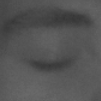

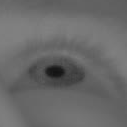

In [11]:
for classe in idx_class.values():
    path_classe = os.path.join(path_test, classe)
    arq_img = os.listdir(path_classe)[1]
    img = Image(filename = os.path.join(path_classe, arq_img))
    display(img)

In [12]:
def train_model(model, metric_error, optimizer, scheduler, epochs):
    history = []
    best_accuracy = 0.0
    best_model = None
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print('\n\nEpoch: {}/{}'.format(epoch + 1, epochs), end=" ")

        model.train()

        error_train = 0.0
        acc_train = 0.0

        error_test = 0.0
        acc_test = 0.0
        
        # Training loop with tqdm progress bar
        training_bar = tqdm(data_loader_train, total=len(data_loader_train), desc="Training", leave=False)
        for i, (enters, labels) in enumerate(training_bar):
            enters = enters.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(enters)
            error = metric_error(outputs, labels)
            error.backward()
            optimizer.step()
            error_train += error.item() * enters.size(0)

            max_values, idx_max_values = torch.max(outputs.data, 1)
            true_pred = idx_max_values.eq(labels.data.view_as(idx_max_values))

            accuracy = torch.mean(true_pred.type(torch.FloatTensor))
            acc_train += accuracy.item() * enters.size(0)

            # Atualizar descrição da barra de progresso
            training_bar.set_postfix({"Error": error.item(), "Accuracy": accuracy.item()})

        # Testing loop with tqdm progress bar
        testing_bar = tqdm(data_loader_test, total=len(data_loader_test), desc="Testing", leave=False)
        with torch.no_grad():
            model.eval()
            for j, (enters, labels) in enumerate(testing_bar):
                enters = enters.to(device)
                labels = labels.to(device)

                outputs = model(enters)
                error = metric_error(outputs, labels)
                error_test += error.item() * enters.size(0)

                max_values, idx_max_values = torch.max(outputs.data, 1)
                true_pred = idx_max_values.eq(labels.data.view_as(idx_max_values))

                accuracy = torch.mean(true_pred.type(torch.FloatTensor))
                acc_test += accuracy.item() * enters.size(0)

                # Atualizar descrição da barra de progresso
                testing_bar.set_postfix({"Error": error.item(), "Accuracy": accuracy.item()})

        mean_error_train = error_train / imgs_train
        mean_acc_train = acc_train / imgs_train

        mean_error_test = error_test / imgs_test
        mean_acc_test = acc_test / imgs_test

        history.append([mean_error_train, mean_error_test, mean_acc_train, mean_acc_test])
        end_epoch = time.time()

        print('Train: Error: {:.4f}, acc {:.4f}%, Test: Error: {:.4f}, acc {:.4f}%'.format(mean_error_train, mean_acc_train * 100, mean_error_test, mean_acc_test * 100), end=" | ")
        
        # Atualizar o scheduler no final da época com a métrica de erro do treinamento
        scheduler.step(mean_error_train)
        
        if mean_acc_test > best_accuracy:
            best_accuracy = mean_acc_test
            model_save_path = '/home/eduardo/projetos/human_eyes/best_model.pt'
            torch.save(model, model_save_path)
            best_model = model
            
            # Salvar o estado do modelo e do otimizador
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'best_accuracy': best_accuracy,
            }
            torch.save(checkpoint, '/home/eduardo/projetos/human_eyes/checkpoint.pth')

    return best_model, history

# Definir função para inicialização de pesos
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight)

# Carregar modelo AlexNet pré-treinado
alexnet = models.alexnet(pretrained=True)

# Aplicar a inicialização de pesos personalizada
alexnet.apply(init_weights)

# Carregar modelo AlexNet pré-treinado
alexnet = models.alexnet(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False

# Modificar o classificador para o número de classes
class_numbers = 2  # Substitua pelo número correto de classes
alexnet.classifier[6] = nn.Linear(4096, class_numbers)
# Adicionar Batch Normalization após as camadas Conv2d
alexnet.features.add_module('7_bn', nn.BatchNorm2d(256))  # Ajuste o número de features conforme necessário
alexnet.features.add_module('8_relu', nn.ReLU(inplace=True))  # Adicione a ativação ReLU
alexnet.classifier.add_module('7', nn.Dropout(0.5))
alexnet.classifier.add_module('8', nn.LogSigmoid())
alexnet.classifier[8] = nn.Softmax(dim=1)

# Adicionar a penalização L2 aos parâmetros do otimizador
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.0001, weight_decay=1e-5)
loss = nn.CrossEntropyLoss()

# Definir o scheduler ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

# Chamar a função de treinamento
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 40
model_trained, history = train_model(alexnet, loss, optimizer, scheduler, num_epochs)

/home/eduardo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)




Epoch: 1/40 

KeyboardInterrupt: 

In [ ]:
# # Extrair informações do histórico
# train_losses = [item[0] for item in history]
# test_losses = [item[1] for item in history]
# train_accuracies = [item[2] for item in history]
# test_accuracies = [item[3] for item in history]

# # Plotar resultados
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(range(1, num_epochs + 1), train_losses, label='Treinamento')
# plt.plot(range(1, num_epochs + 1), test_losses, label='Teste')
# plt.xlabel('Época')
# plt.ylabel('Perda')
# plt.title('Curva de Perda')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(range(1, num_epochs + 1), train_accuracies, label='Treinamento')
# plt.plot(range(1, num_epochs + 1), test_accuracies, label='Teste')
# plt.xlabel('Época')
# plt.ylabel('Acurácia')
# plt.title('Curva de Acurácia')
# plt.legend()

# plt.tight_layout()
# plt.show()